In [3]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
from oggm import utils,cfg,workflow,graphics
from oggm.core.flowline import equilibrium_stop_criterion, FileModel

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import dask
from dask.diagnostics import ProgressBar
import time

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =30
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize'] = 20 #30
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.major.pad']='8'
mpl.rcParams['ytick.major.pad']='8'

In [4]:
dask.config.set({"array.slicing.split_large_chunks": False})

## 1. Read regional output

In [5]:
READING_DIR='out/run_CMIP6_geod'

# read geodetic output
with ProgressBar():
    p = os.path.join(READING_DIR,'07_equilibrium.nc')
    all_ds = xr.open_mfdataset(p, parallel=True)

[########################################] | 100% Completed |  0.2s


In [6]:
all_ds

<xarray.Dataset>
Dimensions:           (rgi_id: 1472, gcm: 14, year: 154)
Coordinates:
  * rgi_id            (rgi_id) object 'RGI60-07.00001' ... 'RGI60-07.01615'
  * gcm               (gcm) object 'CRU' 'CanESM5' ... 'MIROC6'
  * year              (year) int64 1866 1867 1868 1869 ... 2016 2017 2018 2019
Data variables:
    equilibrium       (rgi_id, gcm, year) float64 dask.array<chunksize=(1472, 14, 154), meta=np.ndarray>
    equilibrium_area  (rgi_id, gcm, year) float64 dask.array<chunksize=(1472, 14, 154), meta=np.ndarray>
    run_time          (rgi_id, gcm, year) float64 dask.array<chunksize=(1472, 14, 154), meta=np.ndarray>
Attributes:
    description:    OGGM model output
    oggm_version:   1.5.3.dev14+g25c4675
    calendar:       365-day no leap
    creation_date:  2022-08-02 10:33:18

## 2. Filter errors
Remove glaciers with any Nan-values. But we need to be carefully as not all years are covered by all gcms and CRU

i) Time period covered by all gcms & CRU: 1917-1999

In [8]:
# region 7
r7 = all_ds.sel(rgi_id=all_ds.sel(year=range(1917,1999)).dropna(dim='rgi_id', how='any').rgi_id.values)

ii) Time period covered by all gcms, but NOT by CRU: 1866-1917

In [9]:
r7 = r7.sel(rgi_id=r7.sel(year=range(1866,1917)).drop_sel(gcm='CRU').dropna(dim='rgi_id', how='any').rgi_id.values)

iii) Remaining time period  

In [11]:
r7 = r7.sel(rgi_id=r7.drop_sel(gcm=['CRU','CESM2','GISS-E2-2-H','IPSL-CM6A-LR-INCA','E3SM-1-1'],year=range(1866,2000)).dropna(dim='rgi_id',how='any').rgi_id.values)

In [13]:
len(all_ds.rgi_id)-len(r7.rgi_id)

1003

1003 glaciers are removed --> reached border or CFL error

Calculate the mean over all gcms ! Attention not all have the same time coverage

In [15]:
gcm_mean = xr.merge([r7.equilibrium.drop_sel(gcm='CRU',year=range(2000,2020)).sum(dim='rgi_id').mean(dim='gcm'),
                 r7.equilibrium.drop_sel(gcm=['CRU','CESM2','GISS-E2-2-H','IPSL-CM6A-LR-INCA','E3SM-1-1']).sel(year=range(2000,2020)).sum(dim='rgi_id').mean(dim='gcm')]).equilibrium.load()

Calculate the sum over all rgi_ids

In [16]:
order=['CanESM5', 'NorESM2-MM', 'FGOALS-f3-L','BCC-CSM2-MR', 'MRI-ESM2-0','MPI-ESM1-2-HR','ACCESS-CM2', 'EC-Earth3', 'MIROC6','CESM2','GISS-E2-2-H',
       'IPSL-CM6A-LR-INCA','E3SM-1-1','CRU']
rgi_sum = r7.equilibrium.sum(dim='rgi_id').reindex(gcm=order).load()

## 3. Plot results

In [17]:
from matplotlib import colors
from cycler import cycler

color_list=[colors.to_rgb('#'+c) for c in ["001219","003946","005f73","0a9396","4fb3aa","94d2bd","e9d8a6","ecba53","ee9b00","dc8101","bb3e03","8d210c","5e0314"]]
gcm_cmap = cmap = mpl.colors.ListedColormap(color_list)
custom_cycler = cycler(color=gcm_cmap.colors)


### Global plot

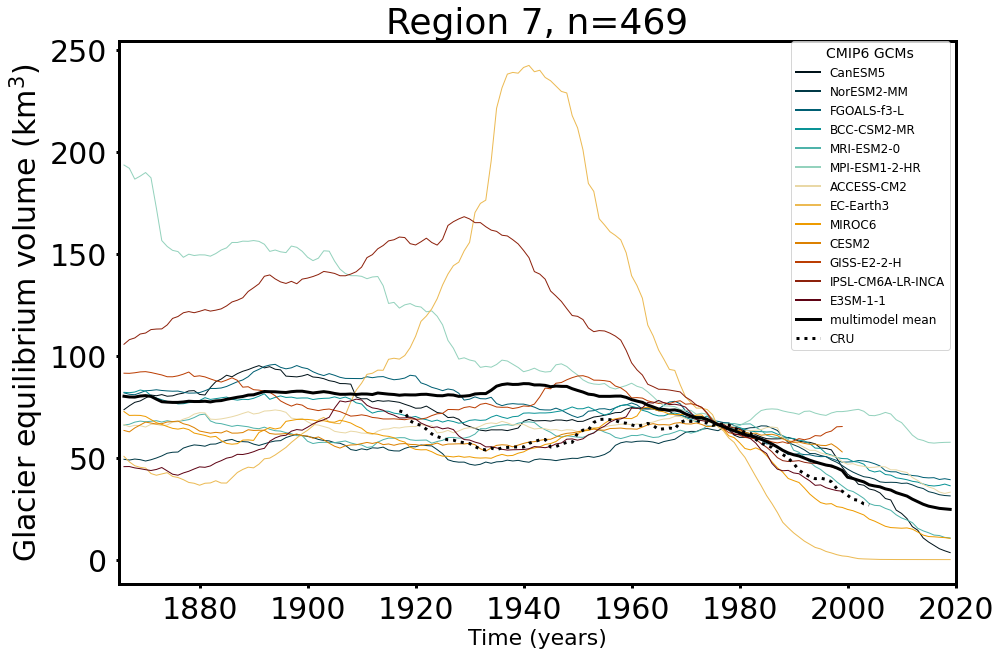

In [24]:
fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('white')
grid = plt.GridSpec(1,1)
ax0 = fig.add_subplot(grid[0])
ax0.set_prop_cycle(custom_cycler)

# plot gcms covering the whole time period
rgi_sum.drop_sel(gcm=['CRU','CESM2','GISS-E2-2-H','IPSL-CM6A-LR-INCA','E3SM-1-1']).plot(hue='gcm',ax=ax0,lw=1)
# plot the gcms that end in year 1999
rgi_sum.sel(gcm=['CESM2','GISS-E2-2-H','IPSL-CM6A-LR-INCA','E3SM-1-1']).sel(year=range(1866,2000)).plot(hue='gcm',ax=ax0,lw=1)
# plot the CRU time series
rgi_sum.sel(gcm='CRU',year=range(1917,2005)).plot(color='k',linestyle=':',ax=ax0)

# plot the mean
gcm_mean.plot(color='k',ax=ax0,lw=3)

ax0.set_title(r'Region 7, n='+str(len(r7.rgi_id.values)))
#ax0.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax0.set_ylabel(r'Glacier equilibrium volume (km$^3$)')

ax0.set_xlim(1865,2020)
ax0.set_xlabel('Time (years)',size=22)

custom_lines =[Line2D([0], [0], color=cmap(i), lw=2) for i,gcm in enumerate(rgi_sum.drop_sel(gcm='CRU').gcm)]+[Line2D([0], [0], color='k', lw=3)]+[Line2D([0], [0], color='k',linestyle=':', lw=3)]
leg = ax0.legend(custom_lines, np.append(rgi_sum.drop_sel(gcm='CRU').gcm.values,['multimodel mean','CRU']),fontsize=12,bbox_to_anchor=(1,1.01))
leg.set_title('CMIP6 GCMs',prop={'size':14});

In [25]:
failed = all_ds.rgi_id.drop_sel(rgi_id=r7.rgi_id.values).load()
failed

<xarray.DataArray 'rgi_id' (rgi_id: 1003)>
array(['RGI60-07.00001', 'RGI60-07.00002', 'RGI60-07.00003', ...,
       'RGI60-07.01613', 'RGI60-07.01614', 'RGI60-07.01615'], dtype=object)
Coordinates:
  * rgi_id   (rgi_id) object 'RGI60-07.00001' ... 'RGI60-07.01615'
Attributes:
    description:  RGI glacier identifier

In [26]:
failed.head()

<xarray.DataArray 'rgi_id' (rgi_id: 5)>
array(['RGI60-07.00001', 'RGI60-07.00002', 'RGI60-07.00003', 'RGI60-07.00005',
       'RGI60-07.00007'], dtype=object)
Coordinates:
  * rgi_id   (rgi_id) object 'RGI60-07.00001' ... 'RGI60-07.00007'
Attributes:
    description:  RGI glacier identifier

In [131]:
 cfg.initialize()

# path to working and plot directory
WORKING_DIR = 'out/run_CMIP6_geod'
cfg.PATHS['working_dir'] = WORKING_DIR

utils.mkdir(cfg.PATHS['working_dir'], reset=False)
cfg.PATHS['plot_dir'] = os.path.join(cfg.PATHS['working_dir'], 'plots')
utils.mkdir(cfg.PATHS['plot_dir'], reset=False)

# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['border']=480

# select Hintereisferner only
gdirs = workflow.init_glacier_directories(failed.head().rgi_id.values)

2022-08-19 13:56:01: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-08-19 13:56:01: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-08-19 13:56:01: oggm.cfg: Multiprocessing: using all available processors (N=32)
2022-08-19 13:56:01: oggm.cfg: Multiprocessing switched ON after user settings.
2022-08-19 13:56:01: oggm.cfg: PARAMS['border'] changed from `40` to `480`.
2022-08-19 13:56:01: oggm.workflow: Execute entity tasks [GlacierDirectory] on 5 glaciers


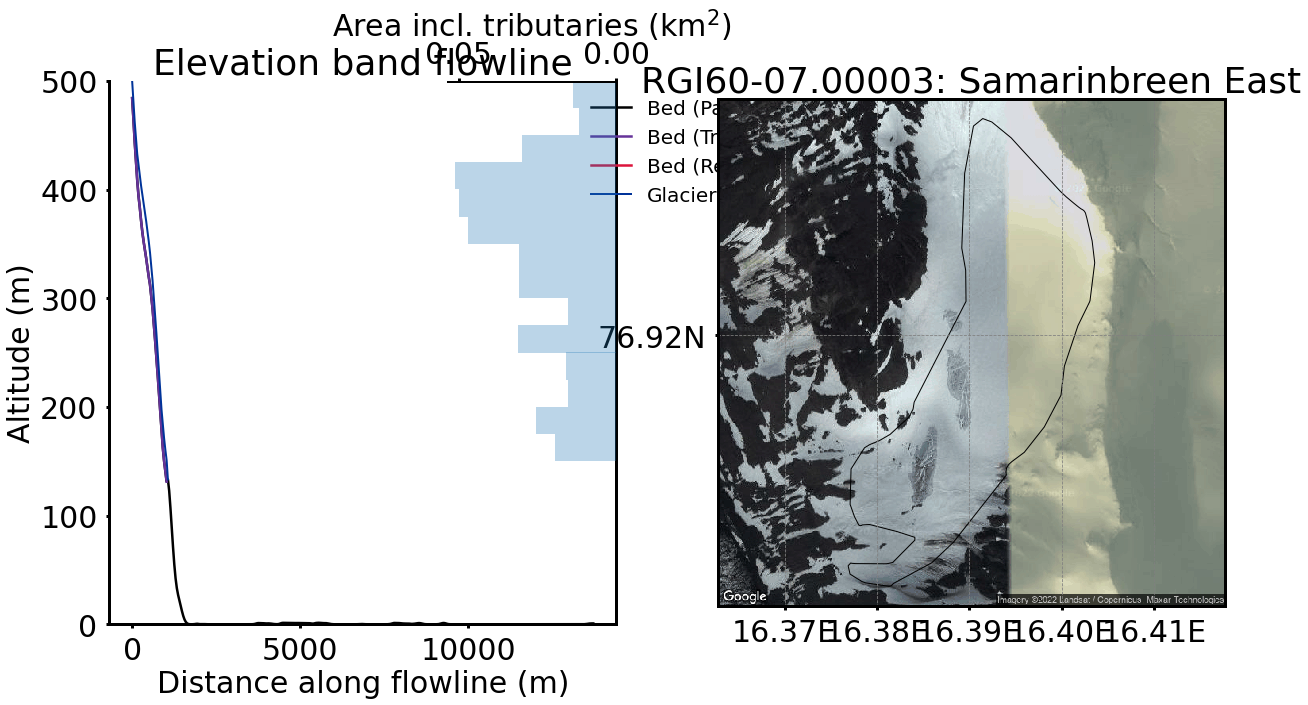

In [90]:
gdir=gdirs[2]
fls = gdir.read_pickle('model_flowlines')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
graphics.plot_modeloutput_section(fls,ax=ax1)
graphics.plot_googlemap(gdir, ax=ax2);
ax1.set_title('Elevation band flowline');

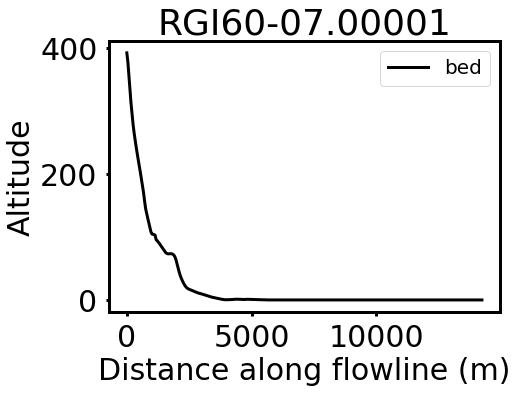

In [163]:
gdir=gdirs[0]
fmod = FileModel(gdir.get_filepath('model_geometry',filesuffix='CRU_2004'))
x = np.arange(fmod.fls[-1].nx) * fmod.fls[-1].dx * \
        fmod.fls[-1].map_dx
plt.figure(figsize=(7,5))
plt.plot(x,fmod.fls[-1].bed_h, color='k',label='bed')
plt.title(gdir.rgi_id)
plt.xlabel('Distance along flowline (m)')
plt.ylabel('Altitude')
plt.legend()
plt.savefig(os.path.join(cfg.PATHS['plot_dir'],'reg_07_bed_example.png'))

In [166]:
os.path.join(gdir.dir,'model_diagnostics_merged.nc')

'out/run_CMIP6_geod/per_glacier/RGI60-07/RGI60-07.00/RGI60-07.00001/model_diagnostics_merged.nc'

In [214]:
ds =  xr.open_dataset(os.path.join(gdir.dir,'model_diagnostics_merged.nc'))
plt.figure(figsize=(20,10))
df = pd.DataFrame()
for yr in ds.year.values:
    df = df.append({'yr': yr, 'l':float(ds.length_m.sel(year=yr,gcm='ACCESS-CM2').dropna(dim='time').rolling(roll_yrs).mean()}, ignore_index=True)
#df.l.plot()

SyntaxError: cannot assign to function call (2468134884.py, line 5)

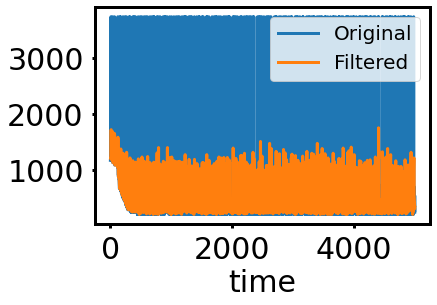

In [248]:
roll_yrs=5
# Take the minimum out of 5 years
ts_orig = ds.length_m.sel(year=1866,gcm='ACCESS-CM2').dropna(dim='time').to_series()
ts = ts_orig.rolling(roll_yrs).mean()
#ts.iloc[0:roll_yrs] = ts.iloc[roll_yrs]
# Plot
ts_orig.plot(label='Original');
ts.plot(label='Filtered');
plt.legend();

AttributeError: 'FileModel' object has no attribute 'water_level'

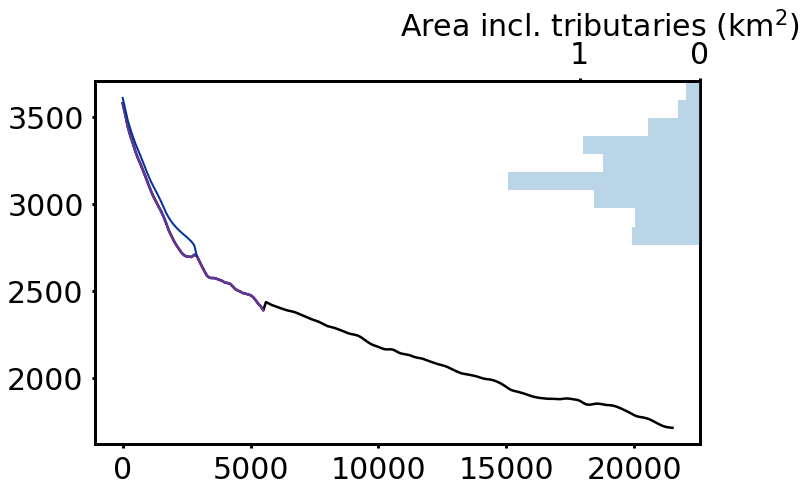

In [130]:
gdir=gdirs[0]
fmod = FileModel(gdir.get_filepath('model_geometry',filesuffix='E3SM-1-1_1999'))
graphics.plot_modeloutput_section(model=fmod)

In [125]:
fmod.do_calving

True

In [129]:
with xr.open_dataset(gdir.get_filepath('model_geometry',filesuffix='E3SM-1-1_1999')) as ds:
    v = ds.calving_m3.values
v

array([ 0.,  0.,  0., ..., nan, nan, nan])

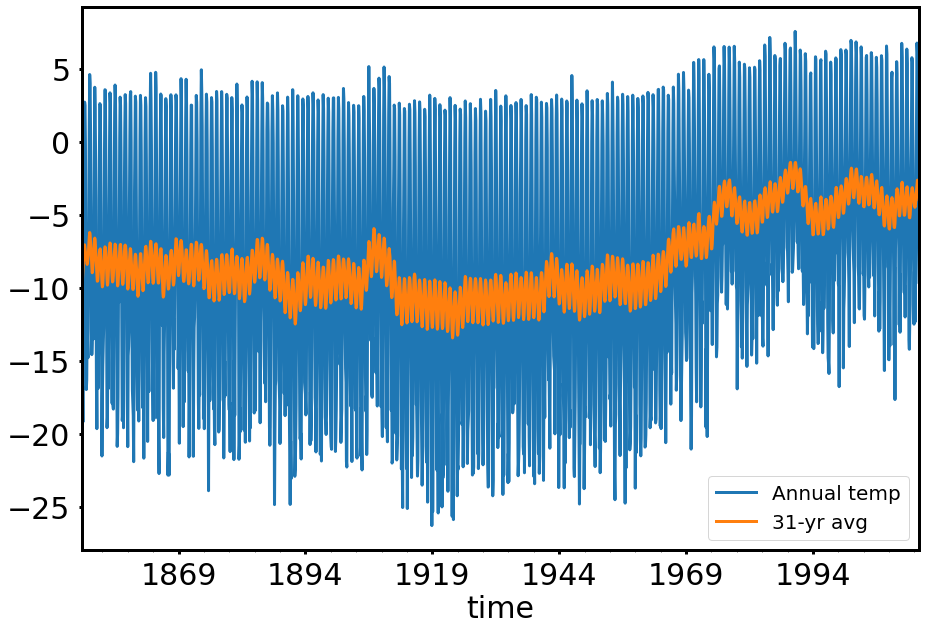

In [55]:
p = 'out/run_CMIP6_geod/per_glacier/RGI60-07/RGI60-07.00/RGI60-07.00001/gcm_dataIPSL-CM6A-LR-INCA.nc'
d = xr.open_dataset(p)
temp = d.temp.resample(time='1MS').mean().to_series()
ax = temp.plot(figsize=(15,10), label='Annual temp')
temp.rolling(31, center=True, min_periods=15).mean().plot(label='31-yr avg')
plt.legend(loc='best')

In [56]:
d.ref_hgt

107.0

In [58]:
p = 'out/run_CMIP6_geod/per_glacier/RGI60-07/RGI60-07.00/RGI60-07.00001/model_flowlines.pkl'


ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
http://xarray.pydata.org/en/stable/user-guide/io.html